<a href="https://colab.research.google.com/github/dlskawns/cp1/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요 모듈 가져오기 

In [ ]:
!pip install squarify
!pip install transformers
!pip install category_encoders
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
from tensorflow.python.types.core import Value
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TFBertModel, BertConfig, BertTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings(action='ignore')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')


### 데이터 불러오기

* 구글 드라이브의 폴더 및 파일을 접근하기 위해 마운트 합니다.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/reviews_project2.csv')
df.rename(columns={'Summary ':'Summary'}, inplace=True)

In [ ]:
df['Summary'].fillna('', inplace=True)

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Reviews.csv')
df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


## 1. EDA 및 특성공학

각 Features의 특징을 면밀히 체크합니다.

특히 Funnel 분석을 위해선 최종적으로 재구매 주기 및 재구매가 줄어든 시점을 파악해봅니다.

In [ ]:
# 수치 데이터 파악
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [ ]:
#결측치 확인
df.isnull().sum()

Id                             0
ProductId                      0
UserId                         0
ProfileName                   16
HelpfulnessNumerator           0
HelpfulnessDenominator         0
Score                          0
Time                           0
Summary                       27
Text                           0
date                           0
dayofweek                      0
r_counts                       0
keyword                        0
labels                    475716
pet                            0
dtype: int64

In [ ]:
# 요약부분 결측치 str 구조로 대체
df['Summary'].fillna('', inplace = True)

df['ProfileName'].fillna('', inplace = True)

---

특성 생성 1. 

타임스탬프 데이터를 통해 리뷰 작성 날짜 인사이트를 파악해봅니다.

해당 날짜를 'date' feature를 생성해 샘플별로 저장합니다.

* 날짜를 통해 고객의 재구매까지 걸리는 기간을 파악 가능
* 날짜 별 분포를 통해 고객 리뷰의 날짜별 패턴 유무 파악 가능

In [ ]:
# 날짜를 변경
df['date'] = pd.to_datetime(df['Time'], unit = 's')
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21
...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,2011-03-09
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,2012-03-09
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",2012-02-21
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,2012-03-13


---

특성 생성 2.

해당 datetime 형식의 'date' feature에서 더 나아가 요일 데이터를 파악해 feature로 만들어 봅니다.

calendar 모듈을 이용해 변경 및 'dayofweek' feature를 생성 및 저장합니다.

* 요일 별 고객 구매행동의 패턴 유무를 파악합니다.

In [ ]:
import calendar

# 요일 특성 생성

df['dayofweek'] = df['date'].map(lambda x: calendar.day_name[x.weekday()])


---

#### 요일 및 별 리뷰 수 분포 

* 주말에 리뷰가 적고 평일에 리뷰 수가 많음.

* 날짜 별 분포로는 전체 중 2012년도에 데이터가 가장 많음  
특별히 더 얻을 정보는 없어 보임

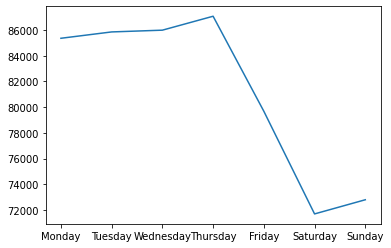

In [ ]:
# 요일 별 리뷰 수 분포
c = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.plot(df['dayofweek'].value_counts().reindex(c).index, df['dayofweek'].value_counts().reindex(c).values);

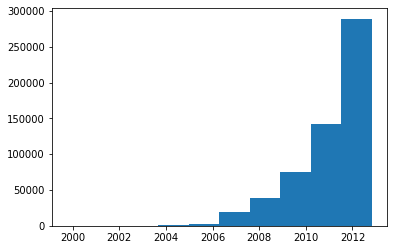

In [ ]:
# 날짜 별 리뷰 수 분포
# plt.bar(df['date'].value_counts().index, df['date'].value_counts().values);
plt.hist(df['date']);
plt.show()

---

특성 생성 3. 

유저 별 리뷰 수를 나타내는 feature를 생성합니다.

* Unique한 UserId 당 몇 개의 샘플을 갖고 있는지 확인 가능  
이를 통해 충성고객 여부 또는 재구매 관련 분석 진행 가능

In [ ]:
# 유저별 리뷰 수 칼럼 생성
df_re = df['UserId'].value_counts().reset_index()
df_re.columns = ['UserId','r_counts']
df = df.join(df_re.set_index('UserId')['r_counts'], on='UserId')

---

#### 유저, 리뷰수, 평점 관계 분포

\* <small> 모든 고객이 상품 구매 후 100% 리뷰를 작성했다고 가정 (리뷰가 없는 데이터가 따로 없으므로)</small>


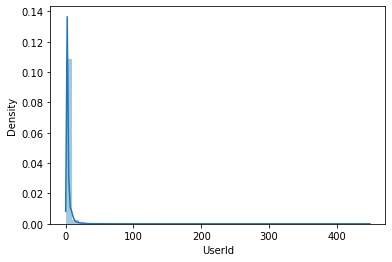

In [ ]:
# 유저 별 리뷰 수 분포
sns.distplot(df['UserId'].value_counts());

In [ ]:
# 리뷰수 구간 별 유저 수
print('리뷰 수 1: ',len(df[df['r_counts']==1]['UserId'].unique()))
print('리뷰 수 2~100: ',len(df[(df['r_counts']<=100) & (df['r_counts'] > 1)]['UserId'].unique()))
print('리뷰 수 100~: ',len(df[df['r_counts'] >= 1]['UserId'].unique()))


리뷰 수 1:  175391
리뷰 수 2~100:  80605
리뷰 수 100~:  256059


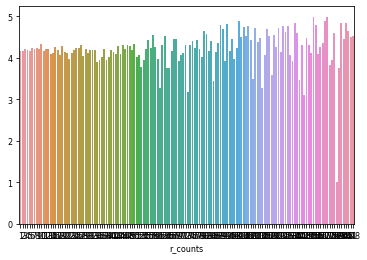

In [ ]:
# 리뷰수 별 평균 평점 > 리뷰를 조금 달았다고 꼭 스코어가 낮은 것은 아니다.

sns.barplot(df.groupby('r_counts')['Score'].mean().index, df.groupby('r_counts')['Score'].mean().values);

plt.show();

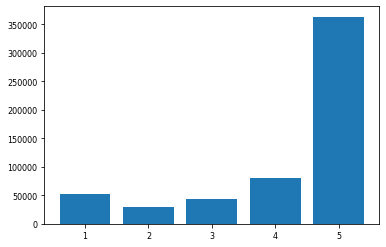

In [ ]:
# 스코어 분포 파악
plt.bar(df['Score'].value_counts().index, df['Score'].value_counts().values);


* 1~30개 정도의 리뷰를 쓴 유저가 가장 많음 >> 구매 불만족으로 인해 리뷰 수(재구매)가 적은 것인지 의문
* 리뷰 수 별 고객 평균 평점분포 확인 >> 리뷰 수가 적다고 평점이 낮지 않음. 고객 이탈과 연관짓기 어려움
* 전체 데이터의 점수 분포 파악 >> 5점이 압도적으로 많아 스코어를 통해 고객 이탈원인 파악이 쉽지 않음

---

#### 리뷰 TOP 10의 개수 및 평점 파악

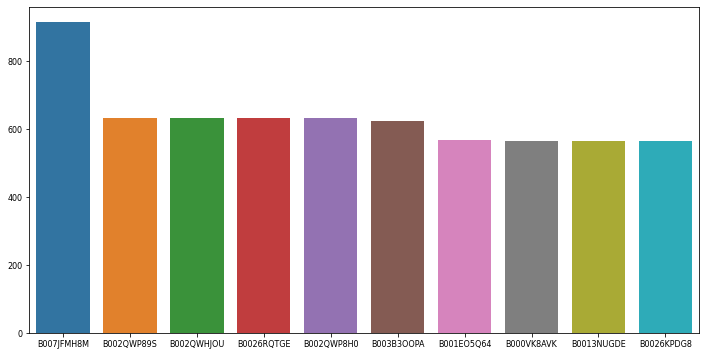

In [ ]:
# 리뷰가 가장 많은 상품 TOP 10 리뷰 개수
product_most = df['ProductId'].value_counts()[:10]
plt.figure(figsize=(12,6))

plt.rc('font', size=8)        # 기본 폰트 크기
sns.barplot(product_most.index, product_most.values);
plt.title('Reviews Top 10')
plt.show();

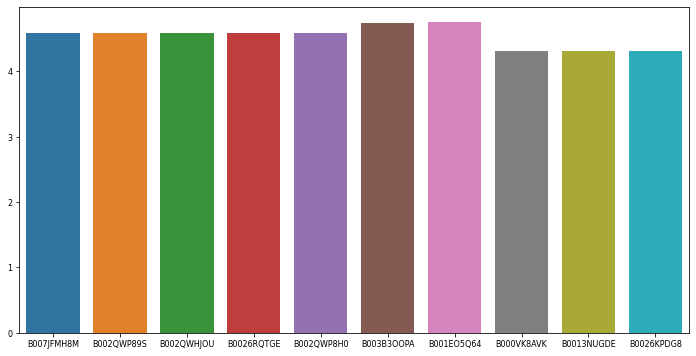

In [ ]:
# 리뷰수 top 10의 스코어 평균 파악
products10_score=[]
for i in range(len(product_most.index)):
  products10_score.append(round(df[df['ProductId']==(product_most.index)[i]]['Score'].mean(),2))
plt.figure(figsize=(12,6))
sns.barplot(product_most.index, products10_score);
plt.rc('font', size=8)        # 기본 폰트 크기
plt.show();

#### (3점 미만의) 리뷰 TOP 10의 개수 및 평점 파악

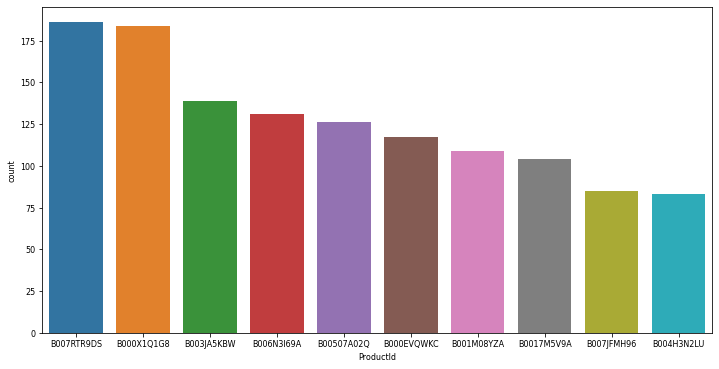

In [ ]:
# 평점이 낮은 상품(3미만)중 리뷰가 많은 상품 개수
plt.figure(figsize=(12,6))
sns.barplot(product_cnt_low_scored.index, product_cnt_low_scored['count']);
plt.rc('font', size=8)        # 기본 폰트 크기
plt.show();

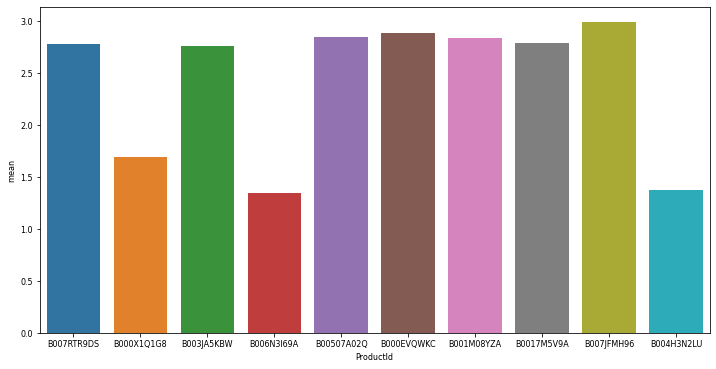

In [ ]:
# 평점이 낮은 상품(3미만)중 리뷰가 많은 상품 평점 평균
product_cnt_low_scored = df.groupby('ProductId')['Score'].agg(['count', 'mean']).sort_values(ascending=False, by= 'count' )
product_cnt_low_scored = product_cnt_low_scored[product_cnt_low_scored['mean']<3][:10]
plt.figure(figsize=(12,6))
sns.barplot(product_cnt_low_scored.index, product_cnt_low_scored['mean']);
plt.rc('font', size=8)        
plt.show();

* 5점을 준 케이스가 많아 TOP 10 상품의 리뷰수 자체가 3점 미만 TOP 10보다 약 4배이상 차이 발생.
* 평점 평균도 큰 의미가 없음

---

특성 생성 5. 

재구매까지 걸리는 기간을 체크합니다.  
같은 고객에 대한 샘플의 날짜 별 정렬을 통해 직전에 구매한 날짜로부터 리뷰작성 당시까지의 기간을 계산

* 고객의 구매 행태 등 관련 인사이트 도출 가능

In [ ]:

# 3. 이전 구매이후 재구매까지 걸린 기간 
day_list = []
df = df[df['r_counts']>1].sort_values(by = ['UserId', 'Time']).reset_index()
for i in range(len(df)):
  print(i)
  if i == 0:
    day_list.append(0)
  elif (df['UserId'][i] == df['UserId'][i-1]) & (df['date'][i] != df['date'][i-1]):
    k = df['date'][i] - df['date'][i-1]
    day_list.append(k.days)
  else:
    day_list.append(0)
df['day_reorder']= day_list

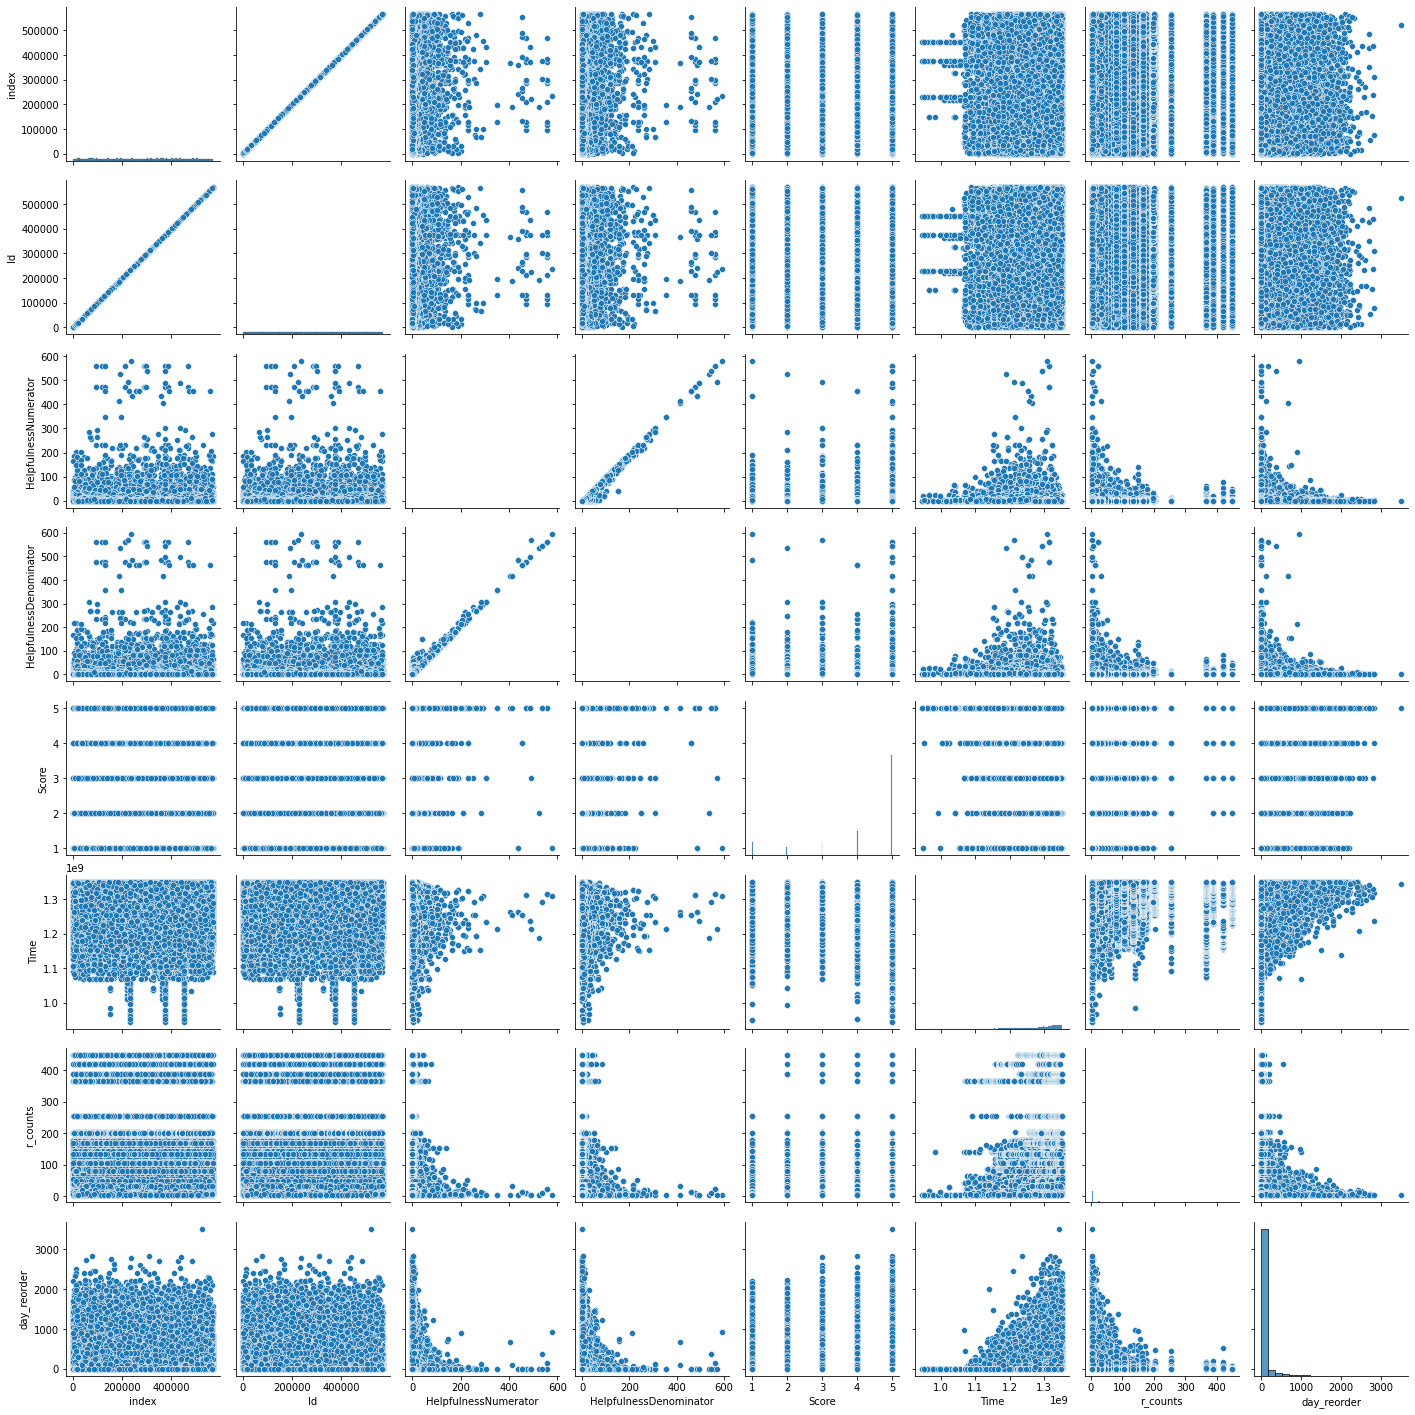

In [ ]:
# 페어플랏을 통해 전체 특성들의 상관관계 한눈에 파악
sns.pairplot(data= df)

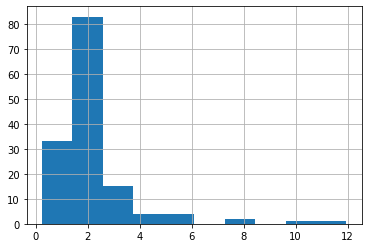

In [ ]:
df.groupby('r_counts')['HelpfulnessNumerator'].mean().hist()
plt.show();

In [ ]:
# helpfulness 계산기
def helpfulness(df):
  a = []
  for i in range(len(df)):
    if df['HelpfulnessDenominator'][i] != 0:
      a.append(round((df['HelpfulnessNumerator'][i] / df['HelpfulnessDenominator'][i]), 2))
    else:
      a.append(0)
  df['Help'] = a
  return df



In [ ]:
helpfulness(df)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date,dayofweek,r_counts,day_reorder,Help
0,83317,83318,B005ZBZLT4,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...,2012-03-12,Monday,2,0,0.67
1,180871,180872,B007Y59HVM,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...,2012-03-12,Monday,2,0,0.67
2,290947,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u...",2012-07-16,Monday,3,0,0.00
3,455533,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u...",2012-07-16,Monday,3,0,0.00
4,496893,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u...",2012-07-16,Monday,3,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393058,361526,361527,B0029XITW2,AZZU4D6TZ2L6J,"Sherry King ""llamasmama""",2,2,5,1247875200,cheese,My father thought this was the best cheese eve...,2009-07-18,Saturday,2,0,1.00
393059,414106,414107,B0029XEXZE,AZZU4D6TZ2L6J,"Sherry King ""llamasmama""",2,2,5,1247875200,cheese,My father thought this was the best cheese eve...,2009-07-18,Saturday,2,0,1.00
393060,312407,312408,B001E5E2QI,AZZV9PDNMCOZW,"Anne B. Ward ""Dr Anne B""",1,1,5,1310428800,Love this syrup,I love this syrup. It is my personal substitut...,2011-07-12,Tuesday,3,0,1.00
393061,338488,338489,B000AXSG2Q,AZZV9PDNMCOZW,"Anne B. Ward ""Dr Anne B""",0,0,5,1329436800,Just what I needed,This is a great addition to my Torani syrup. I...,2012-02-17,Friday,3,220,0.00


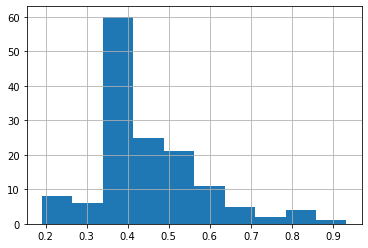

In [ ]:
# 따로 r_counts와 Help의 상관관계는 없어보인다. 
df.groupby('r_counts')['Help'].mean().hist()
plt.show();

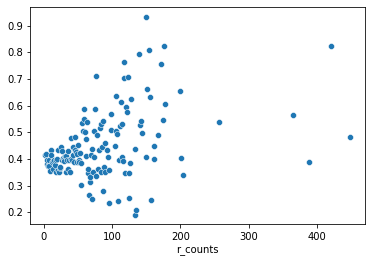

In [ ]:
# 따로 r_counts와 Help의 상관관계는 없어보인다. 
sns.scatterplot(df.groupby('r_counts')['Help'].mean().index, df.groupby('r_counts')['Help'].mean().values)
plt.show();

* day_reorder(재구매까지의 기간)이 낮을 수록 r_counts(리뷰 개수)가 높다.
> = 재구매 기간이 낮고, r_counts(리뷰 개수)가 높은 고객의 리뷰는 방문 빈도 및 구매 빈도가 높은 고객이므로 단골 상품의 키워드 추출이 가능하다.
* day_reorder(재구매까지의 기간)이 낮을 수록 Helpfulness(리뷰 추천 수)가 높다.
> = Helpfulness와 개별 리뷰개수 간의 직접적인 상관관계는 없지만, 재구매 기간이 낮은(구매 빈도가 높은) 고객의 리뷰일 수록 추천 점수가 높은 편이므로, 이러한 고객들의 리뷰는 신뢰할 수 있음.

리뷰 개수가 높은 사람의 리뷰는 신뢰성이 높은 내용일 가능성이 높으므로  
해당 고객의 상품 리뷰 및 평점, 추후에 생성할 키워드 등을 면밀이 분석해 문제의 원인을 찾거나 마케팅 요소를 발견할 수 있음  

---

## 2. Text 분석

### 특징 키워드 분석을 위해 Tokenizing합니다.

* 아래 BertTokenizer를 사용할 예정이지만, EDA로 사용하기에 nltk 모듈의 함수가 다양하므로 nltk로 토큰화를 합니다.  
(ex: most_common, FreqDist 등)
* 몇 차례 반복하면서 TOP50 내의 단어 중 무의미한 단어들을 갖고 있다면 불용어로 처리했습니다.

In [ ]:
# EDA를 위한 불용어 사전 추가

stop_words = stopwords.words('english')
stop_words.extend(['i',
 'me','my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll",
 "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
 "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am',
 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',
 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both',
 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same',
 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",
 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',
 "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
 "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
 "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", '',
 'found','s', 'br',' would', 'nt','one', 'product', 'also','amazon','much','really','time','find','tried',
  'little','used','well','make','could','even','first',
  'like','good','great','flavor','would','love','food','get','use',
  'best','buy','price','better','try','made','bought','flavors',
  'favorite','recommend','way','still','many','think','since','order',
  'bit','go','know','got','give','say','without','something','never',
  'different','easy','ca','every','makes','add','right','day','ordered','lot','always','ever',
  'perfect','however','thought','sure','years','using','definitely','work','back','people','whole',
  'see','oz','purchase','thing','excellent','happy','added','may','going','another','highly','actually',
  'nice','two','tastes','want','delicious','store','though','products','loves','enjoy','keep','put','far',
  'old','pretty','tasty','new','almost','flavored','anythiong','take','wonderful','quite','purchased',
  'usually','came','stores','year','case','tasting','trying','said','several','instead',
  'bad','looking','tasted','need','regular','getting','probably','received','seems','days','months','look',
  'kind','arrived', 'gave','maybe','least','able','absolutely','making','recommended','especially',
  'enough','less','high','per','local','buying','foods','long','anything','real','worth','feel','family',
  'last','things','us','away','amount','around','loved','wo','might','http','company','making','item','three','seeds',
  'taste','fact','href','others','prefer','wish','couple','minutes','works','seem','read','open','available','disappointed','next',
  'g','likes','everyone','difference','son','tell','glad','etc','everything','pieces','longer','others','ones',
  'eats', 'required', 'quality','looks','processed', 'appreciates','labeled','represent',
  'heaven','yummy','story','cs','selling', 'eat', 'food','good','processed', 'better'])
lemmatizer = WordNetLemmatizer()

In [ ]:
# %%time

# 토큰화 진행
tokens = []
for i in range(len(df['Text'])):
  words = word_tokenize(df['Text'][i])
  doc_token =[]

  for token in words:
    token = token.lower()
    token = re.sub(r"[^a-z ]", "", token)
    lemmatizer.lemmatize(token)
    if token not in stop_words:
      doc_token.append(token)

  tokens.append(doc_token)

df['token'] = tokens

### 품사 별 빈도가 많은 단어 추출
JJ & NN 위주 
어떤 것을 disgusting 하는지 파악

In [ ]:
# nltk.help.upenn_tagset()
pos_nn, pos_jj, pos_vbp = [],[], []
for i in vocab.most_common(200):
  a= pos_tag([i[0]])[0][1]
  if a == 'NN' or a == 'NNS':
    pos_nn.append(i)
  elif a == 'JJ':
    pos_jj.append(i)

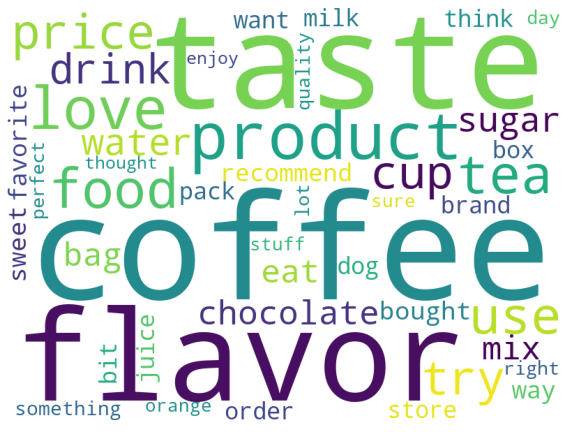

In [ ]:

# from collections import Counter
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',width=800, height=600)
cloud = wordcloud.generate_from_frequencies(dict(pos_nn))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

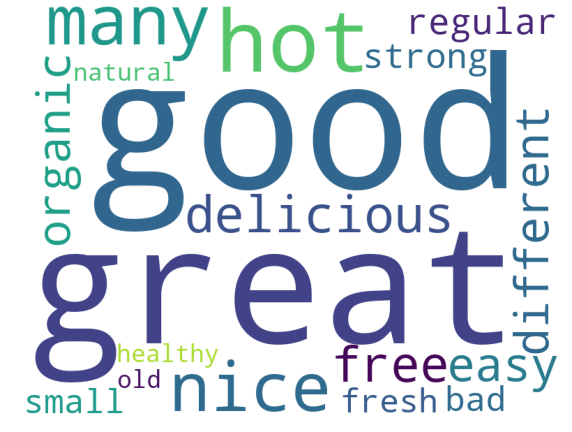

In [ ]:
wordcloud = WordCloud(background_color='white',width=800, height=600)
cloud = wordcloud.generate_from_frequencies(dict(pos_jj))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

### 감성 단어관련 불용어 처리 진행

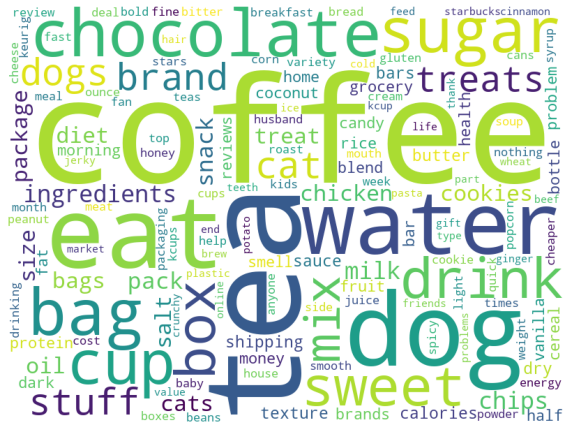

In [ ]:

# from collections import Counter
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',width=800, height=600)
cloud = wordcloud.generate_from_frequencies(dict(pos_nn))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

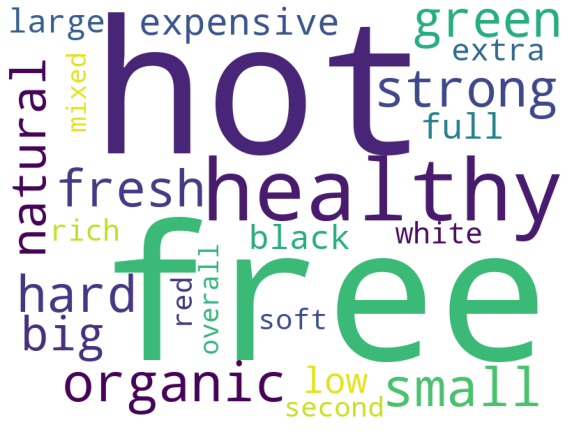

In [ ]:
wordcloud = WordCloud(background_color='white',width=800, height=600)
cloud = wordcloud.generate_from_frequencies(dict(pos_jj))
plt.figure(figsize=(10,8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

### 데이터셋 total 명사 키워드 Top 50 분석

1. coffee, tea 등 drinks 관련 상품이 리뷰가 많은 것을 볼 수 있다.

2. sauce, chips, chocolate 등 상품 키워드가 존재한다.

3. dog, cat 등 반려동물용 상품이 존재하는 것을 알 수 있다.


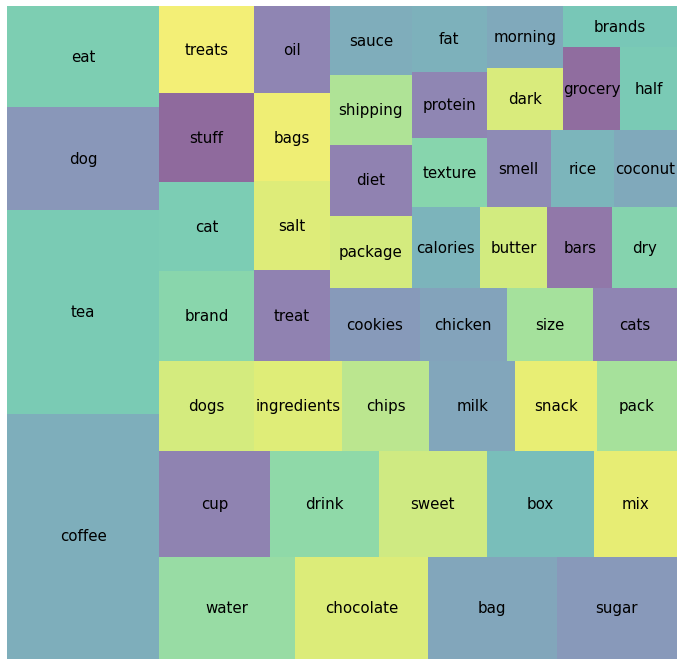

In [ ]:
import squarify
import matplotlib.pyplot as plt


plt.figure(figsize=(12,12))
plt.rc('font', size= 15);
squarify.plot(sizes=words_cnts_pos_nn['counts'], label=words_cnts_pos_nn['words'], alpha=0.6);
plt.axis('off');
plt.show();

### 데이터셋 total 형용사 키워드 Top 25 분석

1. organic, healthy, natural 등 건강기능식품에 대한 관심 및 키워드가 자주 언급되었다.

2. hard, soft, hot 등의 감각 및 지각 관련 키워드가 있음

3. free, low 및 strong, mixed 등 영양소와 관련되어 보이는 키워드가 존재


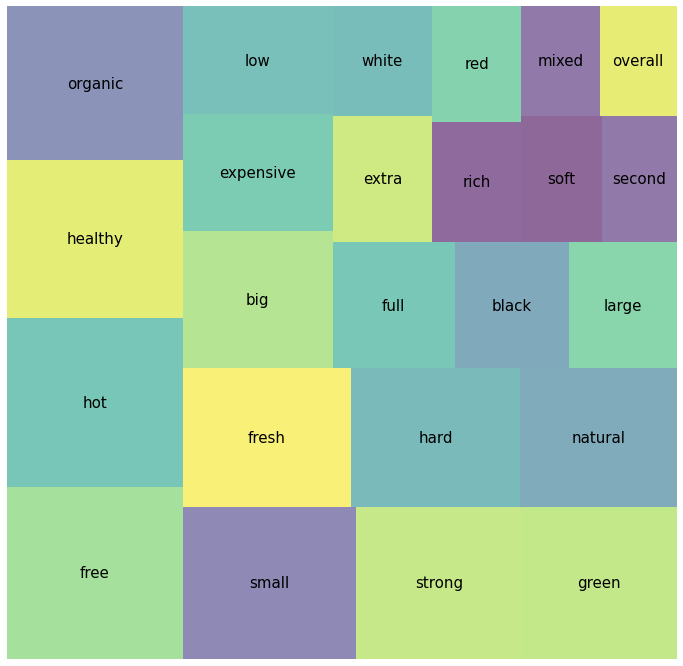

In [ ]:
plt.figure(figsize=(12,12))
plt.rc('font', size= 15);
squarify.plot(sizes=words_cnts_pos_jj['counts'], label=words_cnts_pos_jj['words'], alpha=0.6);
plt.axis('off');
plt.show();